In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
d = pd.read_csv("sample_clean.csv")
rnlabel = "variability amplitude $R_\mathrm{per}$\n normalized by Kepler photometric precision"
rlabel = "variability amplitude $R_\mathrm{per}$ (ppm)"
pnlabel = r"$\mathrm{Ro}=P_\mathrm{rot}/\tau_\mathrm{c}$"
dtlabel = 'empirical detection threshold'
tefflabel = 'LAMOST $T_\mathrm{eff}$ (K)'
protlabel = 'rotation period $P_\mathrm{rot}$ (days)'

## McQuillan searched sample

In [5]:
dm14 = pd.concat([pd.read_csv("data/mcquillan+14.tsv", delimiter="|", comment="#"), pd.read_csv("data/m14_nodet.tsv", comment='#', delimiter='|')])
dm14["kepid"] = dm14.KIC
dm14 = dm14.reset_index(drop=True)
dkic = pd.read_csv("data/kepler_stellar_17.csv", comment='#', delimiter="|")
dm14 = pd.merge(dm14, dkic[['kepid', 'kepmag']], on='kepid')

In [6]:
dg = pd.read_csv("data/DR2PapTable1.txt", delimiter='&')
dg['kepid'] = dg.KIC
dm14 = pd.merge(dm14, dg, on='kepid')

In [7]:
dm14.to_csv("sample_M14_searched.csv", index=False)

## Where is the edge?

In [10]:
resdir = "mcquillan_edge/"

In [11]:
from scipy.interpolate import interp1d
dprec = pd.read_csv("data/kepler_precision.txt", delim_whitespace=True)
kepsigma = interp1d(dprec.kepmag, dprec.long, kind='cubic')

Text(0, 0.5, 'variability amplitude $R_\\mathrm{per}$ (ppm)')

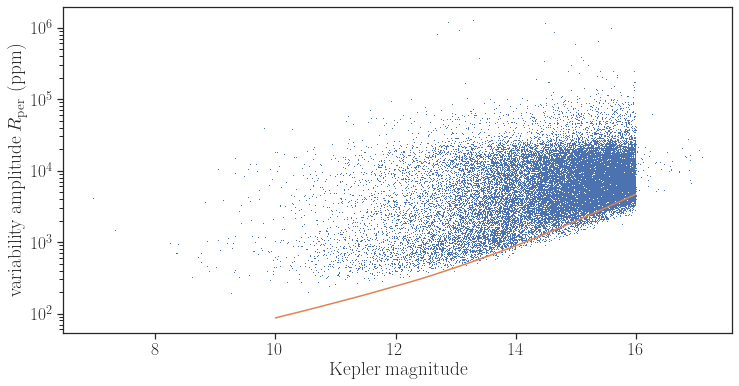

In [12]:
x = np.linspace(10, 16, 100)
plt.yscale("log")
plt.plot(dm14.kepmag, dm14.Rper, ',')
plt.plot(x, kepsigma(x)*3)
plt.xlabel("Kepler magnitude")
plt.ylabel(rlabel)

In [13]:
def simulate_rdist(dm14, dm14bright, cut=3.):
    kepall = np.array(dm14.kepmag)
    kepall[kepall<7] = 7.
    ret = np.array([])
    for i in range(10):
        rall = np.random.choice(np.array(dm14bright.Rper), len(dm14))
        ret = np.r_[ret, rall[rall>cut*kepsigma(kepall)]]
    return ret

In [14]:
idxt = (4000 < dm14.teff) & (dm14.teff < 6500)
dm14bright = dm14[(dm14.kepmag<12.)&idxt].reset_index(drop=True)

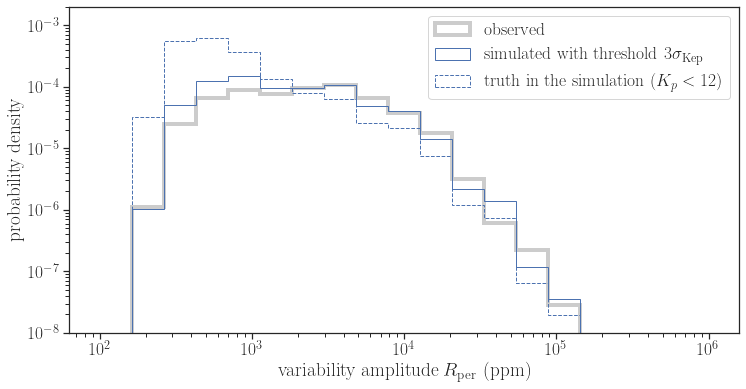

In [15]:
bins = np.logspace(2, 6, 20)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-8, 2e-3)
plt.ylabel("probability density")
plt.xlabel(rlabel)
plt.hist(dm14.Rper[idxt], bins=bins, density=True, histtype='step', color='gray', lw=4, alpha=0.4, label='observed')
#plt.hist(simulate_rdist(dm14[idxt].reset_index(drop=True), dm14bright, cut=2.), bins=bins, density=True, histtype='step',
#        label='simulated with threshold $2\sigma_\mathrm{Kep}$', ls='dotted')
plt.hist(simulate_rdist(dm14[idxt].reset_index(drop=True), dm14bright, cut=3.), bins=bins, density=True, histtype='step',
        label='simulated with threshold $3\sigma_\mathrm{Kep}$')
#plt.hist(simulate_rdist(dm14[idxt].reset_index(drop=True), dm14bright, cut=4.), bins=bins, density=True, histtype='step',
#        label='simulated with threshold $4\sigma_\mathrm{Kep}$', ls='dashed')
plt.hist(dm14bright.Rper, bins=bins, density=True, histtype='step', 
         lw=1, ls='dashed', color='C0', label='truth in the simulation ($K_p<12$)')
plt.legend(loc='upper right')
plt.savefig(resdir+"rperdist_simulation.png", dpi=200, bbox_inches="tight")

## At which Ro do the stars hit the edge?

In [14]:
params_all = {"robreak": 0.84, "Rbreak": 1.08e4, "bsat": -0.04, "bunsat": -2.61, "lnrsigma": 0.55}
params_mag = {"robreak": 0.99, "Rbreak": 9.7e3, "bsat": -0.02, "bunsat": -4.55, "lnrsigma": 0.59}

In [15]:
tau_g98 = lambda teff: 314.24 * np.exp(-(teff/1952.5)-(teff/6250.)**18) + 0.002

def rper_ro(ro, p, scatter=False):
    ro = np.atleast_1d(ro)
    ret = (ro/p['robreak'])**p['bsat']
    idx = ro > p['robreak']
    ret[idx] = (ro[idx]/p['robreak'])**p['bunsat']
    if not scatter:
        return ret * p['Rbreak']
    else:
        lnR = np.log(ret * p['Rbreak']) + np.random.randn(len(ret))*p['lnrsigma']
        return np.exp(lnR)

def ro_threshold(mags, params, sigma_th=3.):
    magarr = np.atleast_1d(mags)
    magarr = np.where(magarr < 7, 7, magarr)
    ros = np.linspace(0, 10, 10000)
    rpers = rper_ro(ros, params)
    rper_th = sigma_th * kepsigma(magarr)
    return ros[np.argmin(np.abs(rpers[:,None] - rper_th[None,:]), axis=0)]

In [16]:
mags = np.linspace(5, 18, 1000)

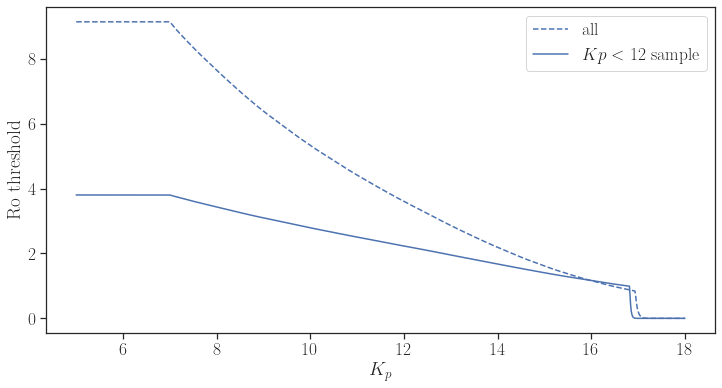

In [17]:
plt.ylabel("Ro threshold") # sigma=3
plt.xlabel("$K_p$")
rocut_all = interp1d(mags, ro_threshold(mags, params_all))
rocut_mag = interp1d(mags, ro_threshold(mags, params_mag))
plt.plot(mags, ro_threshold(mags, params_all), label='all', ls='dashed', color='C0')
#plt.plot(mags, rocut_all(mags))
plt.plot(mags, ro_threshold(mags, params_mag), label='$Kp<12$ sample', ls='solid', color='C0')
#plt.plot(mags, rocut_mag(mags))
plt.legend(loc='best')
plt.savefig(resdir+"roth_kepmag.png", dpi=200, bbox_inches="tight")

In [18]:
dm14['rocut_all'] = rocut_all(dm14.kepmag)
dm14['rocut_mag'] = rocut_mag(dm14.kepmag)

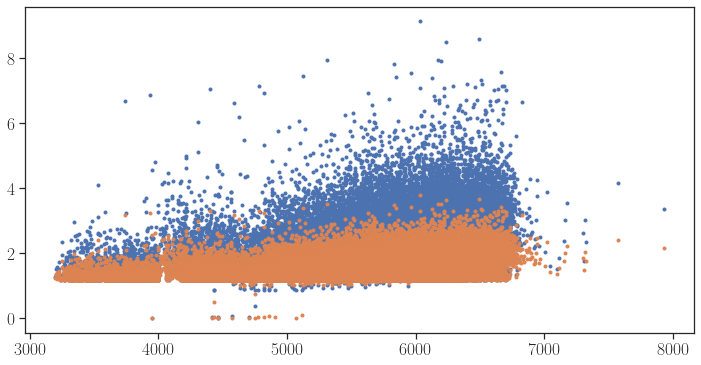

In [19]:
plt.plot(dm14.teff, dm14.rocut_all, '.')
plt.plot(dm14.teff, dm14.rocut_mag, '.')

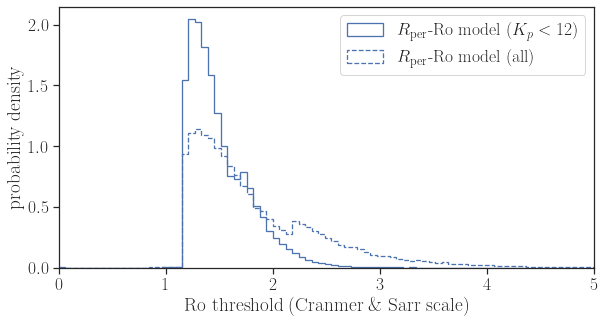

In [20]:
ro0 = np.linspace(0, 6, 100)
plt.figure(figsize=(12*0.8, 6*0.8))
plt.xlim(0., 5)
plt.xlabel("Ro threshold (Cranmer \& Sarr scale)")
plt.ylabel("probability density")
plt.hist(dm14.rocut_mag, bins=ro0, density=True, label='$R_\mathrm{per}$-$\mathrm{Ro}$ model ($K_p<12$)', 
         histtype='step', color='C0', ls='solid', lw=1.3)
plt.hist(dm14.rocut_all, bins=ro0, density=True, label='$R_\mathrm{per}$-$\mathrm{Ro}$ model (all)', 
         histtype='step', color='C0', ls='dashed', lw=1.3)
plt.legend(loc='best')
plt.savefig(resdir+"roth_hist.png", dpi=200, bbox_inches="tight")

In [21]:
def pdetfunc(ros):
    rocuts = np.array(ros)
    return interp1d(np.r_[-np.inf, np.sort(rocuts), np.inf], np.r_[1, np.cumsum(rocuts)[::-1]/np.cumsum(rocuts)[-1], 0.], kind='linear')

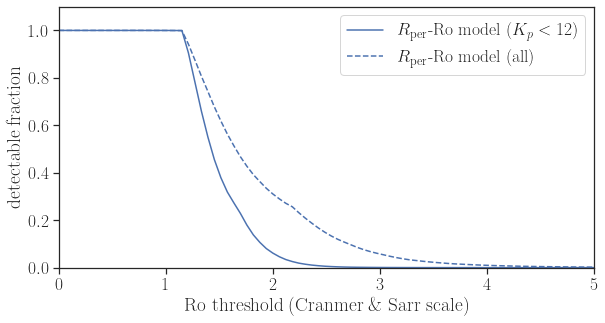

In [22]:
plt.figure(figsize=(12*0.8, 6*0.8))
plt.xlim(0, 5)
plt.ylim(0, 1.1)
#plt.axvline(x=1.15, color='gray')
plt.ylabel("detectable fraction")
plt.xlabel("Ro threshold (Cranmer \& Sarr scale)")
plt.plot(ro0, pdetfunc(dm14.rocut_mag)(ro0), label='$R_\mathrm{per}$-$\mathrm{Ro}$ model ($K_p<12$)', 
         color='C0', ls='solid')
plt.plot(ro0, pdetfunc(dm14.rocut_all)(ro0), label='$R_\mathrm{per}$-$\mathrm{Ro}$ model (all)', 
         color='C0', ls='dashed')
plt.legend(loc='best')
#plt.hist(dm14.rocut_all, density=True, cumulative=-1, bins=100)
#plt.hist(dm14.rocut_mag, density=True, cumulative=-1, bins=100);
plt.savefig(resdir+"pdet_ro.png", dpi=200, bbox_inches="tight")

## Effect on Ro distribution

In [23]:
pdet_all = pdetfunc(dm14.rocut_all)
pdet_mag = pdetfunc(dm14.rocut_mag)
x = np.linspace(0, 6, 10000)

In [24]:
def simulate_ro(func, ro_true, label='', dlabel='detectability function', dls='dotted'):
    plt.figure(figsize=(12*0.9,6*0.9))
    plt.xlabel("$\mathrm{Ro}$")
    plt.ylabel("probability")
    plt.xlim(0, 4.)
    plt.hist(ro_true, histtype='step', lw=5, bins=100, density=True, alpha=0.5, color='gray',
             label='true $\mathrm{Ro}$ distribution')
    plt.plot(x, func(x), ls=dls, label=dlabel, lw=1)
    plt.hist(ro_true, histtype='step', lw=2, bins=100, weights=func(ro_true)/np.sum(func(ro_true)), density=True, 
             label='observed $\mathrm{Ro}$ distribution')
    plt.legend(loc='best')
    #plt.hist(d.Pnorm[(tmin<d.teff)&(d.teff<tmax)], bins=bins, density=True, histtype='step')
    plt.savefig(resdir+"rodist"+label+".png", dpi=200, bbox_inches='tight')

In [25]:
ro_true = np.random.randn(int(1e6))*0.5 + 2.
ro_true = ro_true[ro_true>0.]

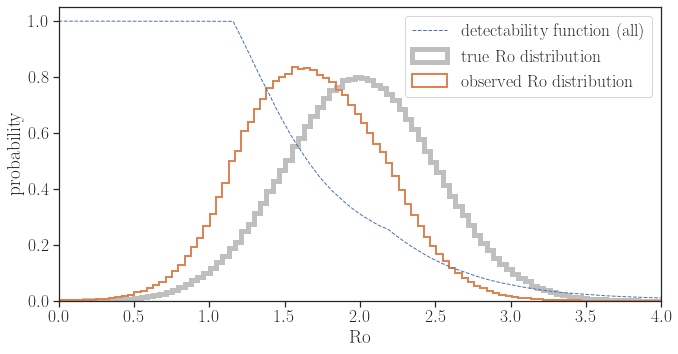

In [26]:
simulate_ro(pdet_all, ro_true, label='gauss-all', dls='dashed', dlabel='detectability function (all)')

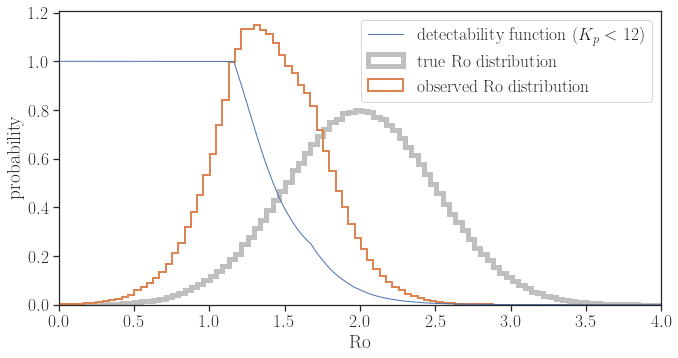

In [27]:
simulate_ro(pdet_mag, ro_true, label='gauss-mag', dls='solid', dlabel='detectability function ($K_p<12$)')

In [28]:
# uniform age distribution
ages = np.random.rand(int(1e7))*10.
prots = 25 * np.sqrt(ages/4.6)
ros_uage = prots / tau_g98(5777.)
print ('detected fraction:', np.sum(pdet_mag(ros_uage)) / len(ros_uage))

detected fraction: 0.2814453825841332


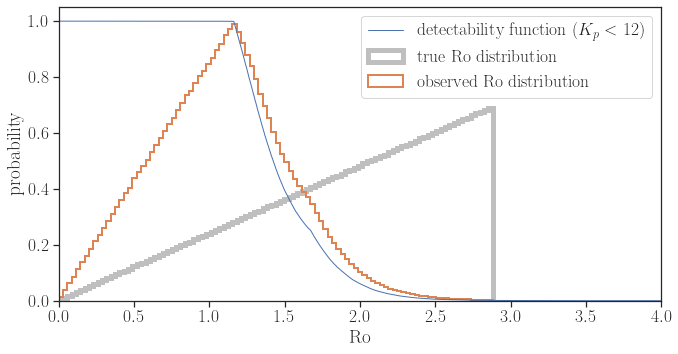

In [29]:
simulate_ro(pdet_mag, ros_uage, label='uage_sun', dls='solid', dlabel='detectability function ($K_p<12$)')

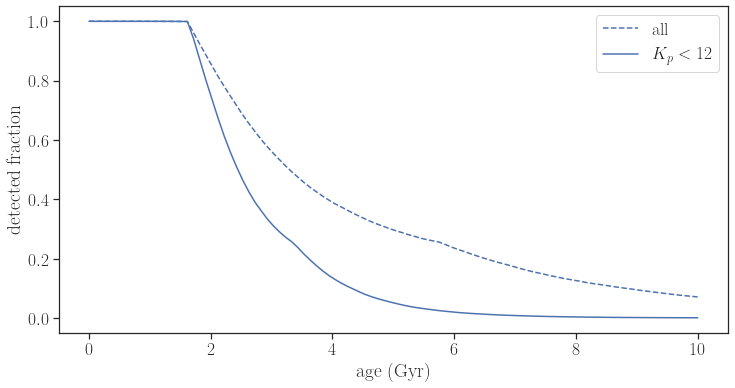

In [30]:
ages = np.linspace(0, 10, 100)
prots = 25 * np.sqrt(ages/4.6)
ros = prots / tau_g98(5777.)
plt.xlabel("age (Gyr)")
plt.ylabel("detected fraction")
plt.plot(ages, pdet_all(ros), label='all', ls='dashed')
plt.plot(ages, pdet_mag(ros), ls='solid', label='$K_p<12$', color='C0')
plt.legend(loc='best')
plt.savefig(resdir+"pdet_age_sun.png", dpi=200, bbox_inches="tight")

## Leaky threshold

In [52]:
def pfunc(rnorm, cut, power):
    ret = np.ones_like(rnorm)
    idx = rnorm < cut
    ret[idx] = (rnorm[idx]/cut)**power
    return ret

def pdet_leaky(mags, params, sigma_th=3., power=1):
    magarr = np.atleast_1d(mags)
    magarr = np.where(magarr < 7, 7, magarr)
    ros = np.linspace(0., 10, 1000)
    rpers = rper_ro(ros, params)
    rnorms = rpers[:,None] / kepsigma(magarr)[None,:]
    pdets = pfunc(rnorms, cut=sigma_th, power=power)
    return ros, np.mean(pdets, axis=1)

In [55]:
ros, pdets = pdet_leaky(dm14.kepmag, params_mag, power=1.2)

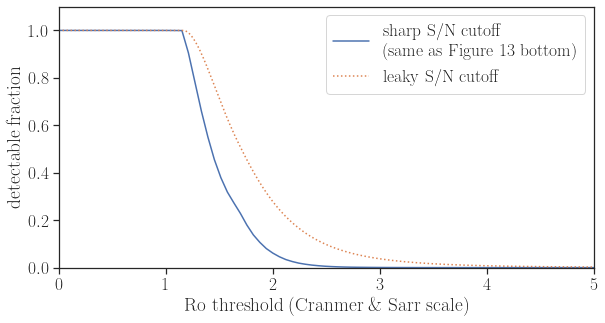

In [60]:
plt.figure(figsize=(12*0.8, 6*0.8))
plt.xlim(0, 5)
plt.ylim(0, 1.1)
plt.ylabel("detectable fraction")
plt.xlabel("Ro threshold (Cranmer \& Sarr scale)")
plt.plot(ro0, pdetfunc(dm14.rocut_mag)(ro0), #label='$R_\mathrm{per}$-$\mathrm{Ro}$ model ($K_p<12$)', 
         color='C0', ls='solid', label='sharp S/N cutoff\n(same as Figure 13 bottom)')
plt.plot(ros, pdets, color='C1', ls='dotted', label='leaky S/N cutoff')
plt.legend(loc='best')
plt.savefig(resdir+"pdet_ro_leaky.png", dpi=200, bbox_inches="tight")

## simulate period distribution

In [50]:
def simulate_pdetection(ds, prot, params):
    ros = prots / tau_g98(ds.teff)
    rpers = rper_ro(ros, params, scatter=True)
    rper_th = 3 * kepsigma(ds.kepmag)
    return pd.DataFrame(data={"Prot": prot, "Pnorm": ros, "Rper": rpers, "idxdet": rpers > rper_th})

In [51]:
# From Masuda et al. (2022)
tl, tu = 5800., 6100
ds = dm14[(tl<dm14.teff) & (dm14.teff)].reset_index(drop=True)
prots = 10** (np.random.randn(len(ds))*0.19 + 1.18)

In [52]:
# Lower temperature
tl, tu = 5500., 6000
ds = dm14[(tl<dm14.teff) & (dm14.teff)].reset_index(drop=True)
prots = 10** (np.random.randn(len(ds))*0.19 + 1.18 + 0.1)

In [53]:
dsim = simulate_pdetection(ds, prots, params_mag)

In [54]:
print ("detected fraction:", np.sum(dsim.idxdet)/len(dsim))

detected fraction: 0.2690673072481175


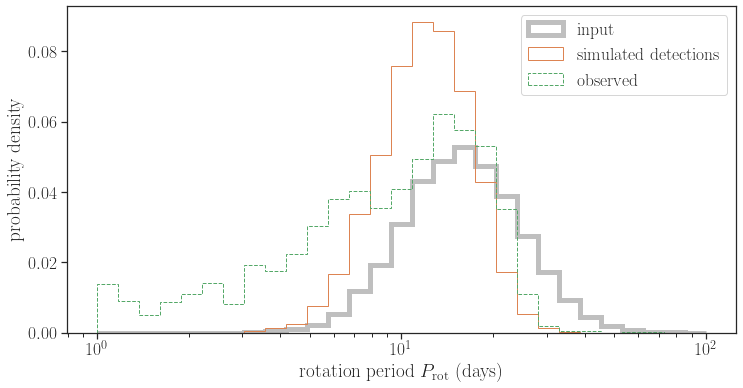

In [55]:
#bins = np.linspace(0, 60, 50)
bins = np.logspace(0, 2, 30)
plt.xscale("log")
plt.xlabel(protlabel)
plt.ylabel("probability density")
plt.hist(dsim.Prot, density=True, bins=bins, histtype='step', label='input', 
         lw=5, alpha=0.5, color='gray')
plt.hist(dsim.Prot[dsim.idxdet], density=True, bins=bins, histtype='step', color='C1', label='simulated detections')
plt.hist(d[(tl<d.teff)&(d.teff<tu)].Prot, density=True, bins=bins, histtype='step', 
         ls='dashed', label='observed', color='C2')
plt.legend(loc='best')
plt.savefig(resdir+"pdist_masuda22.png", dpi=200, bbox_inches='tight')

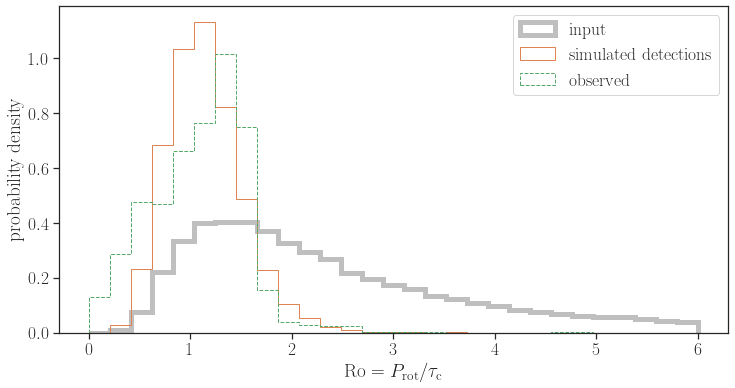

In [56]:
bins = np.linspace(0, 6, 30)
#bins = np.logspace(0, 6, 50)
#plt.xscale("log")
plt.xlabel(pnlabel)
plt.ylabel("probability density")
plt.hist(dsim.Pnorm, density=True, bins=bins, histtype='step', label='input', 
         lw=5, alpha=0.5, color='gray')
plt.hist(dsim.Pnorm[dsim.idxdet], density=True, bins=bins, histtype='step', color='C1', label='simulated detections')
plt.hist(d[(tl<d.teff)&(d.teff<tu)].Pnorm, density=True, bins=bins, histtype='step', 
         ls='dashed', label='observed', color='C2')
plt.legend(loc='best')
plt.savefig(resdir+"pndist_masuda22.png", dpi=200, bbox_inches='tight')

## Plot Rnorm vs Ro

In [361]:
resdir = 'mcquillan_edge/rnorm/'
tbins = np.arange(4000, 6500, 150)
logg_threshold = 4.
R_th = 3.

mcquillan_edge/teff4000-4150
10.3922 43.075799999999994
mcquillan_edge/teff4150-4300
11.8288 40.07039999999998
mcquillan_edge/teff4300-4450
10.594000000000001 42.69
mcquillan_edge/teff4450-4600
9.7415 39.4255
mcquillan_edge/teff4600-4750
10.24125 38.049499999999995
mcquillan_edge/teff4750-4900
8.2715 36.906
mcquillan_edge/teff4900-5050
8.21695 34.303650000000005
mcquillan_edge/teff5050-5200
7.65085 35.06465
mcquillan_edge/teff5200-5350
7.007499999999999 32.5819
mcquillan_edge/teff5350-5500
5.9175 29.5266
mcquillan_edge/teff5500-5650
5.8566 26.188999999999997
mcquillan_edge/teff5650-5800
4.3340000000000005 22.68275
mcquillan_edge/teff5800-5950
3.354 19.6812
mcquillan_edge/teff5950-6100
2.5210500000000002 20.06225
mcquillan_edge/teff6100-6250
1.8767500000000001 16.266
mcquillan_edge/teff6250-6400
1.4138000000000002 18.688999999999997


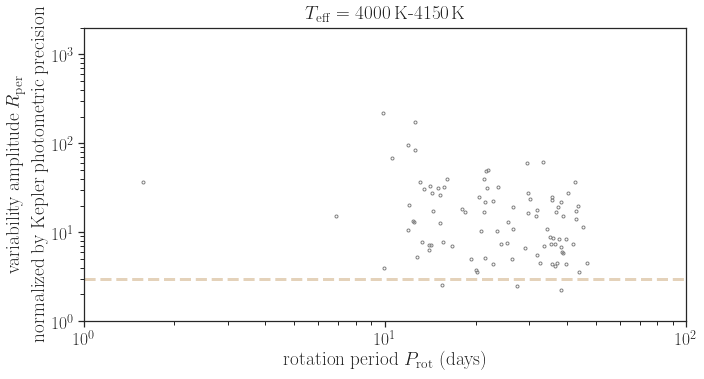

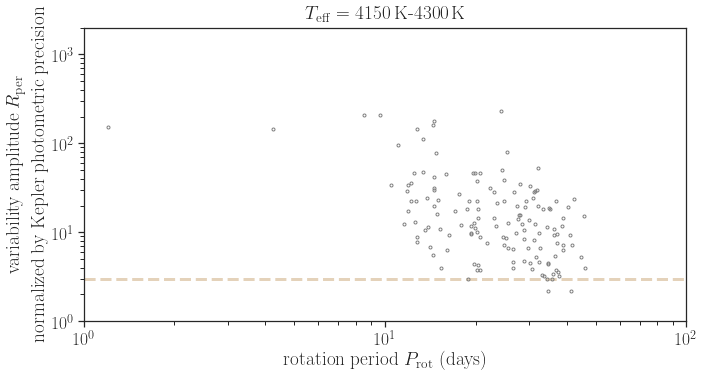

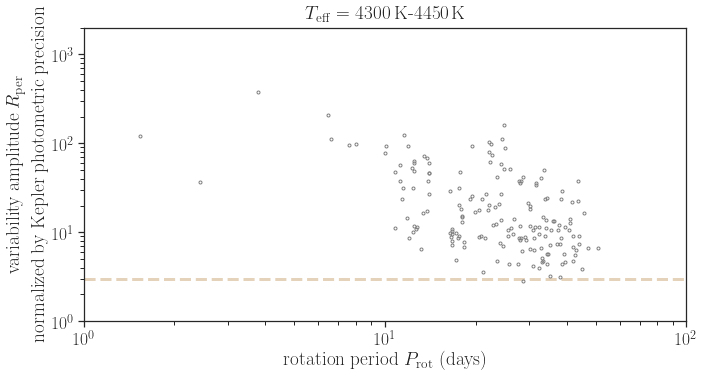

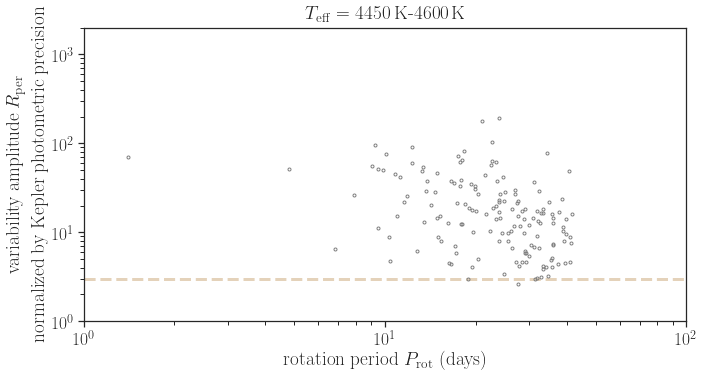

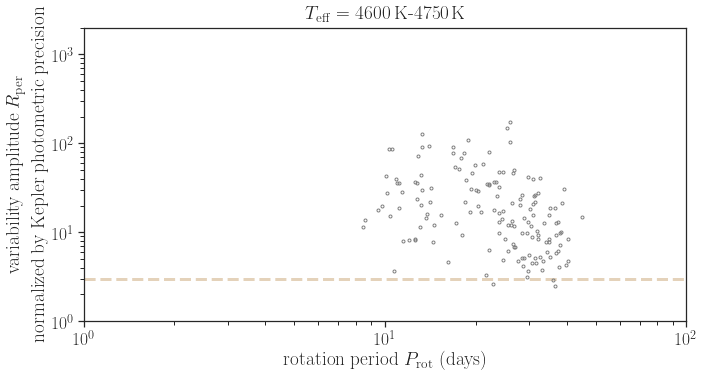

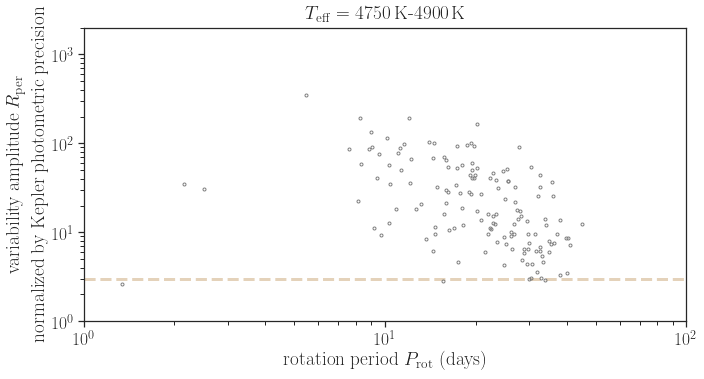

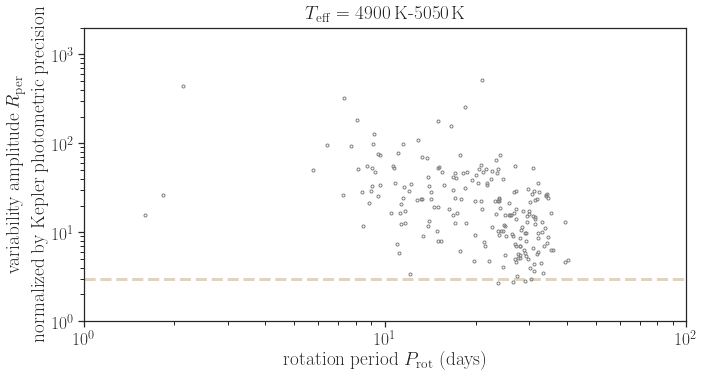

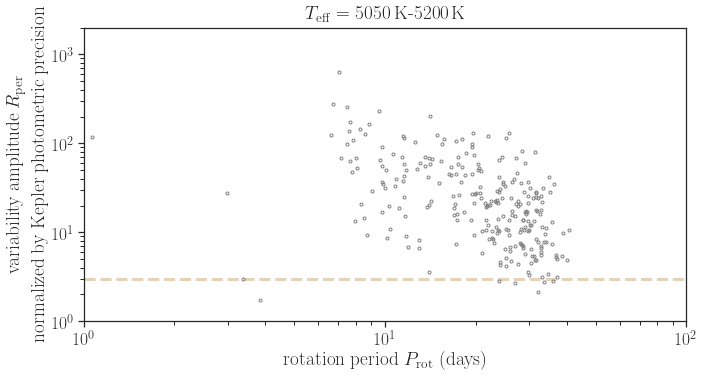

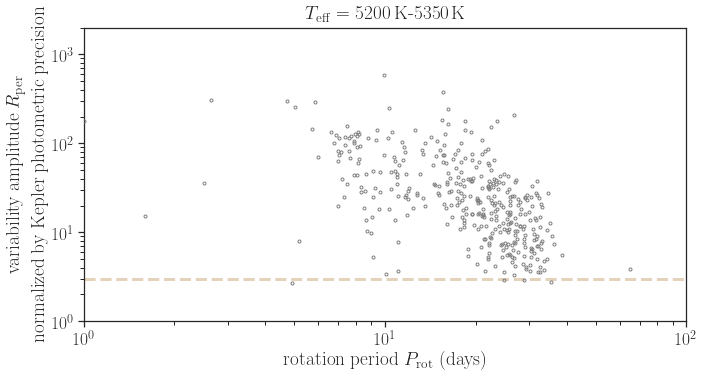

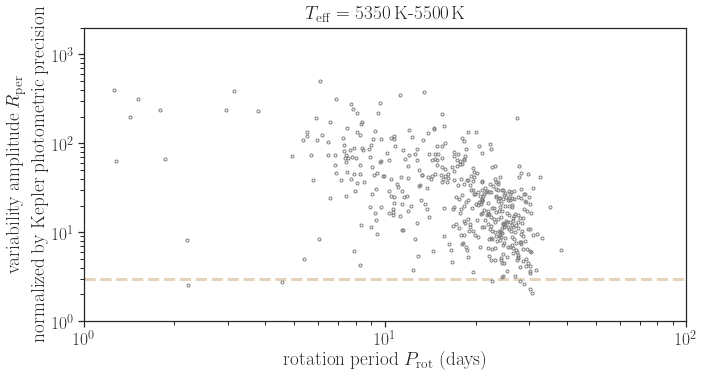

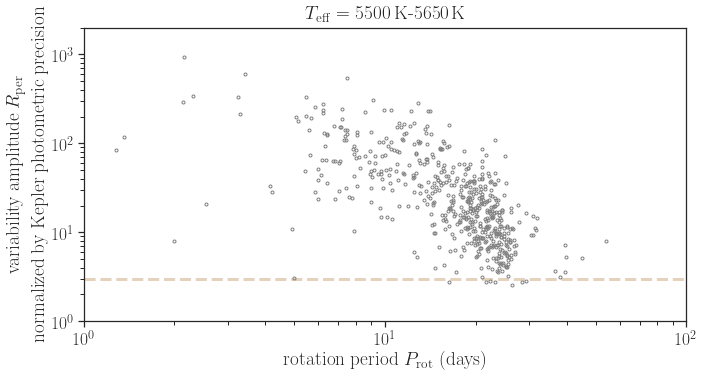

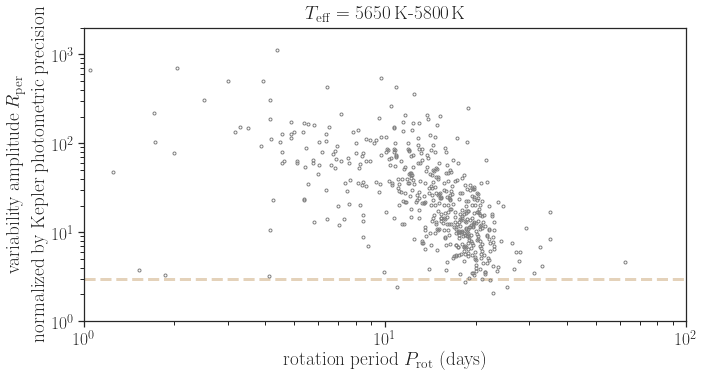

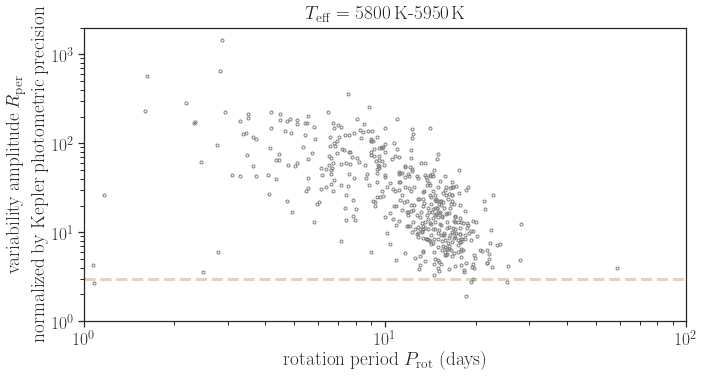

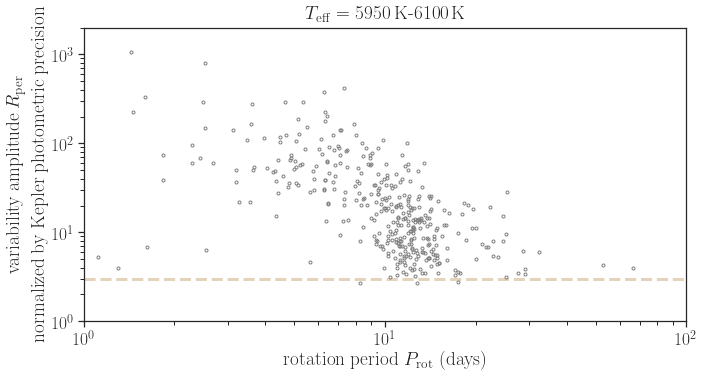

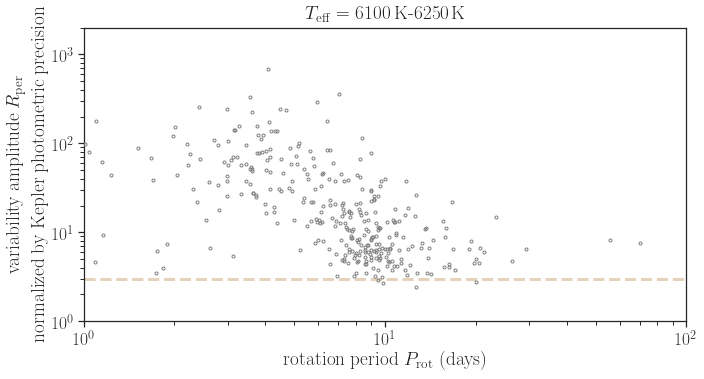

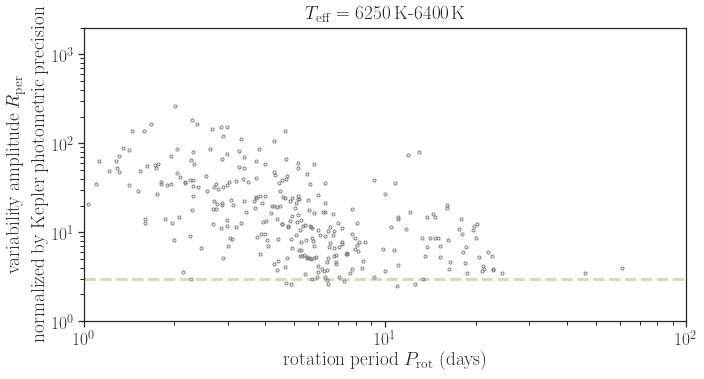

In [364]:
rc('text', usetex=True)
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Prot, [5, 95])
    print (pmin, pmax)
    
    idxp = d.Prot > 0
    pobs, robs = jnp.array(d[idx&idxp].Prot), jnp.array(d[idx&idxp].Rnorm)

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    #plt.ylim(1e1, 1e6)
    plt.ylim(1, 2e3)
    plt.xlim(1, 100)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rnlabel)
    plt.xlabel(protlabel)
    plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=1, zorder=1000, label='data')
    plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
    #plt.legend(loc='lower left')
    plt.savefig(outname+"_rnorm_p.png", dpi=200, bbox_inches="tight")

mcquillan_edge/teff4000-4150
10.3922 43.075799999999994
mcquillan_edge/teff4150-4300
11.8288 40.07039999999998
mcquillan_edge/teff4300-4450
10.594000000000001 42.69
mcquillan_edge/teff4450-4600
9.7415 39.4255
mcquillan_edge/teff4600-4750
10.24125 38.049499999999995
mcquillan_edge/teff4750-4900
8.2715 36.906
mcquillan_edge/teff4900-5050
8.21695 34.303650000000005
mcquillan_edge/teff5050-5200
7.65085 35.06465
mcquillan_edge/teff5200-5350
7.007499999999999 32.5819
mcquillan_edge/teff5350-5500
5.9175 29.5266
mcquillan_edge/teff5500-5650
5.8566 26.188999999999997
mcquillan_edge/teff5650-5800
4.3340000000000005 22.68275
mcquillan_edge/teff5800-5950
3.354 19.6812
mcquillan_edge/teff5950-6100
2.5210500000000002 20.06225
mcquillan_edge/teff6100-6250
1.8767500000000001 16.266
mcquillan_edge/teff6250-6400
1.4138000000000002 18.688999999999997


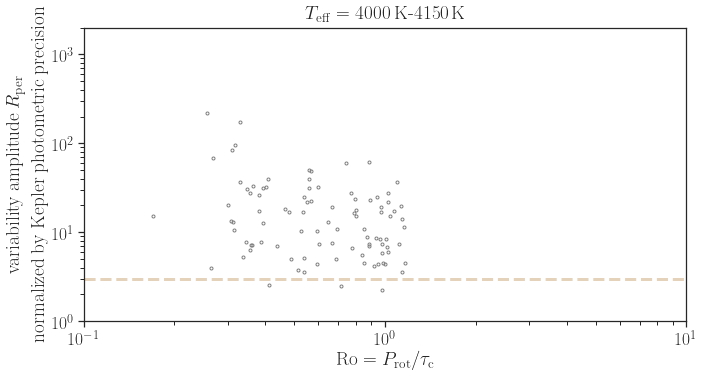

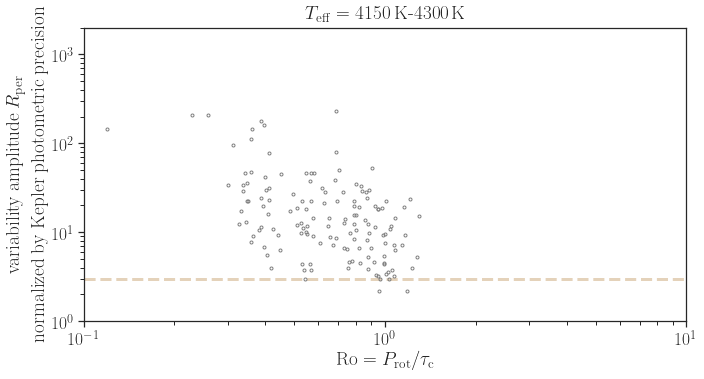

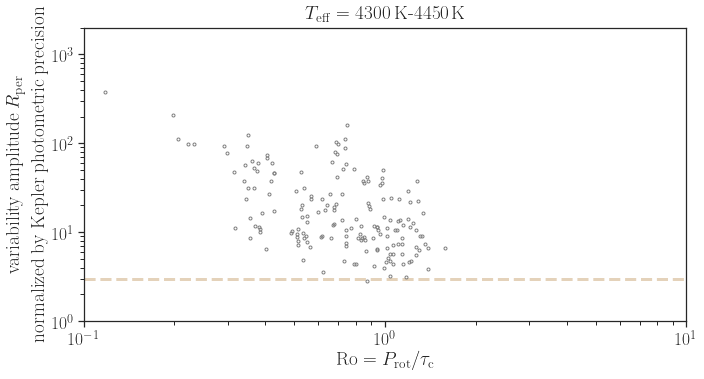

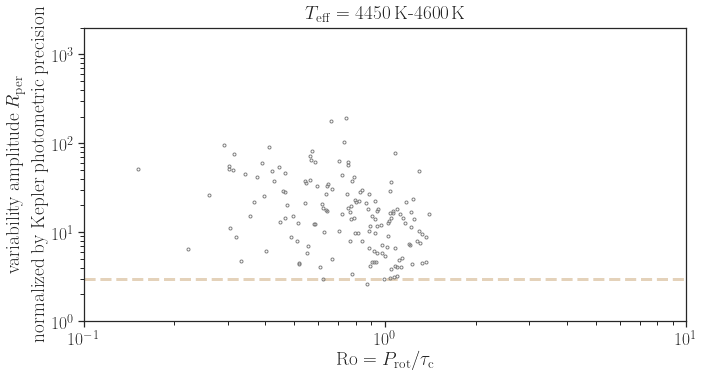

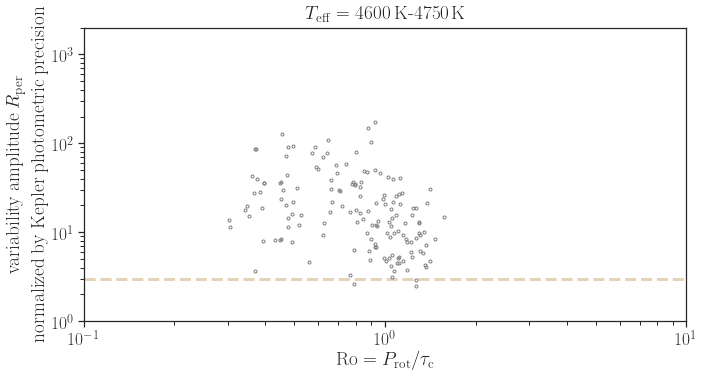

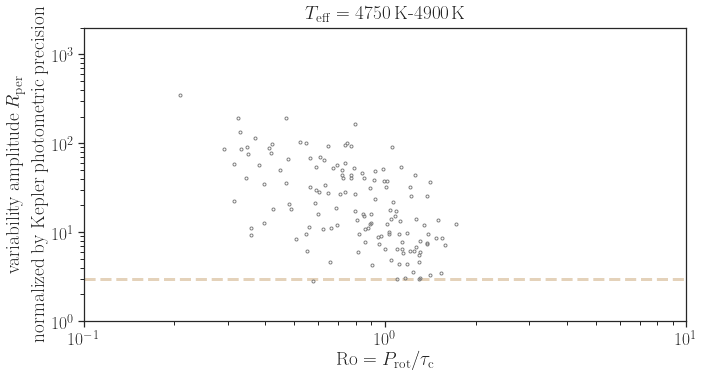

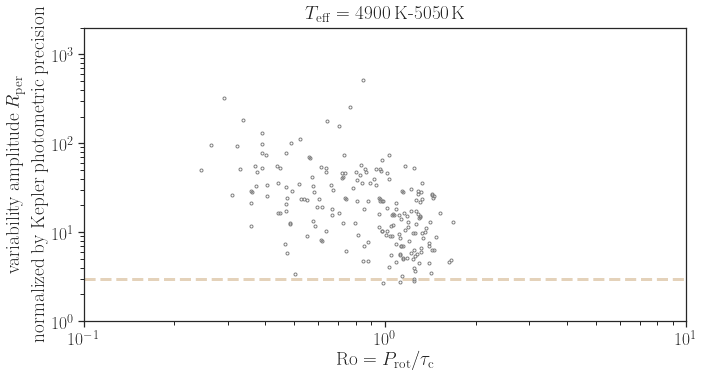

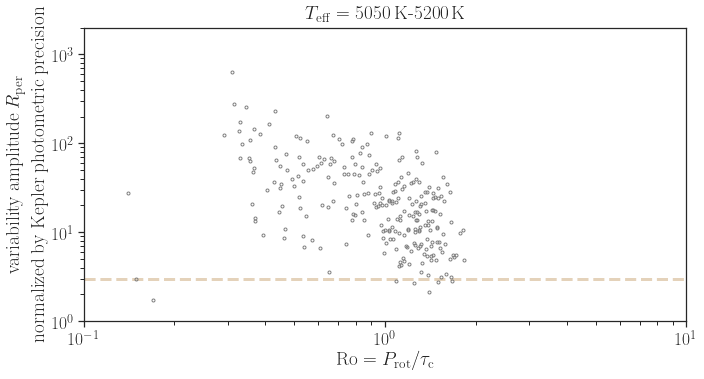

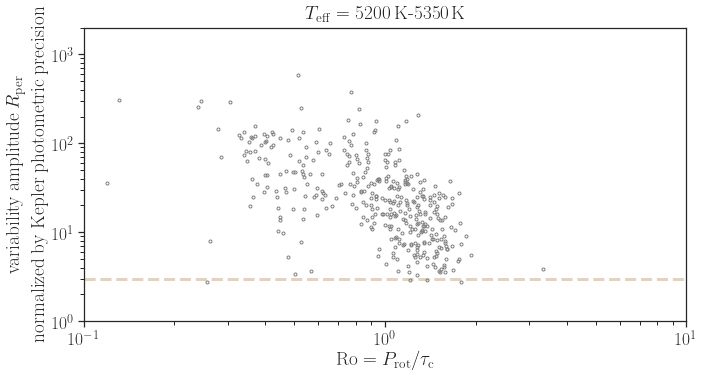

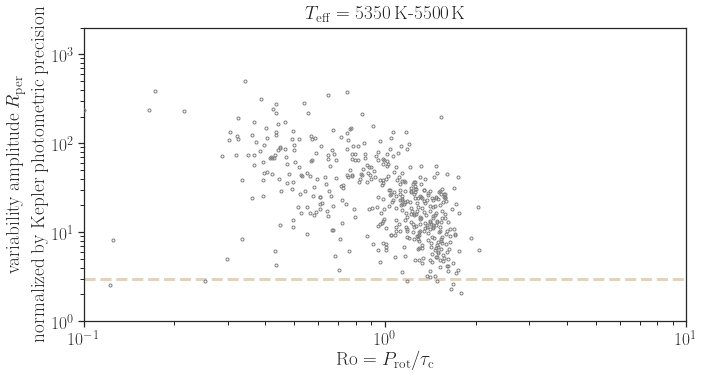

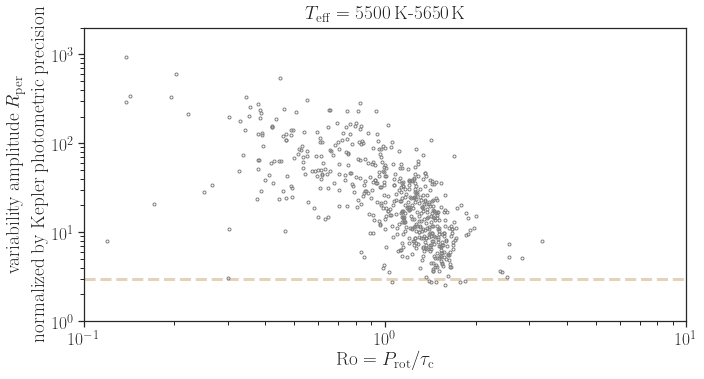

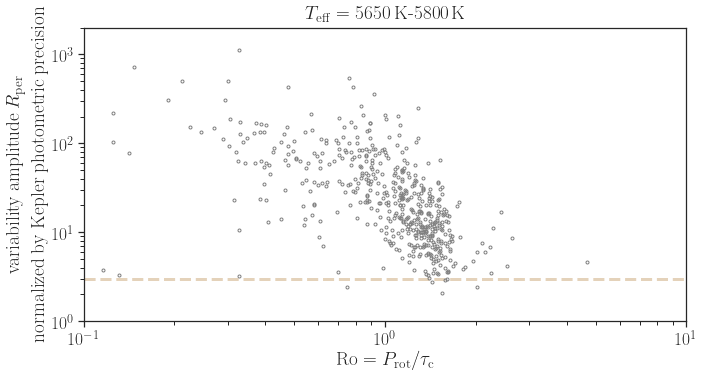

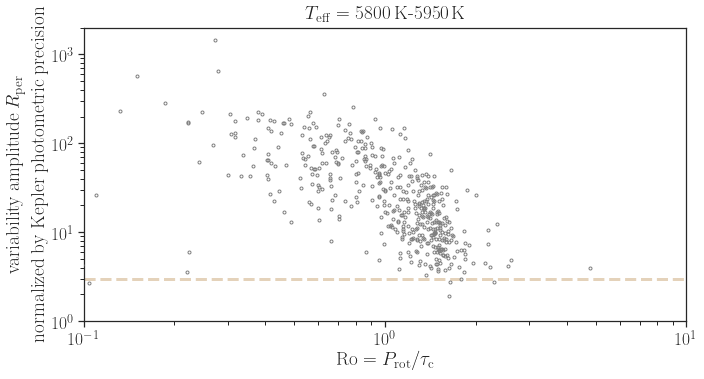

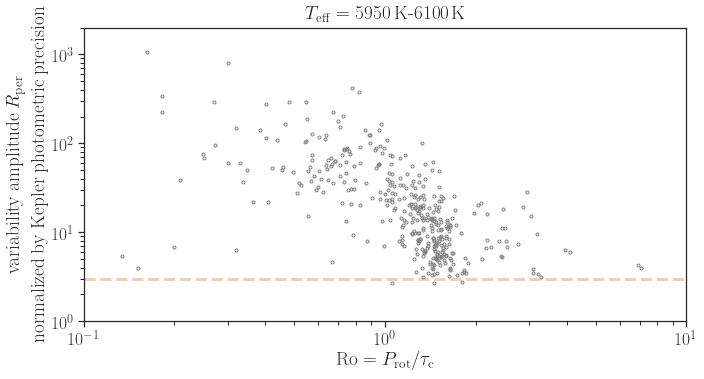

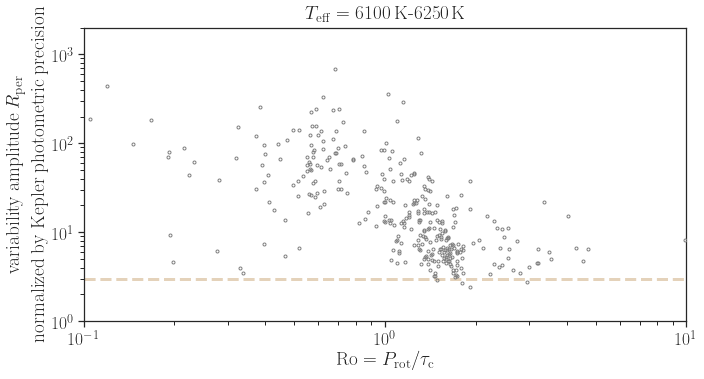

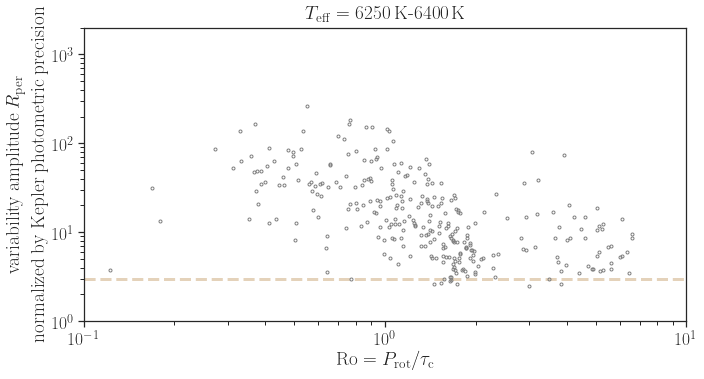

In [369]:
rc('text', usetex=True)
for i in range(len(tbins)-1):
    tl, tu = tbins[i], tbins[i+1]
    outname = resdir+"teff%d-%d"%(tl, tu)
    print (outname)    

    idx = (d.teff>tl) & (d.teff<tu) & (d.logg>logg_threshold)
    pmin, pmax = np.percentile(d[idx].Prot, [5, 95])
    print (pmin, pmax)
    
    idxp = d.Prot > 0
    pobs, robs = jnp.array(d[idx&idxp].Pnorm), jnp.array(d[idx&idxp].Rnorm)

    plt.figure(figsize=(12*0.9,6*0.9))
    plt.title("$T_\mathrm{eff}=%d\,\mathrm{K}$-$%d\,\mathrm{K}$"%(tl, tu))
    plt.ylim(1, 2e3)
    plt.xlim(0.1, 10)
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(rnlabel)
    plt.xlabel(pnlabel)
    plt.plot(pobs, robs, '.', color='gray', mfc='none', mew=1, zorder=1000, label='data')
    plt.axhline(y=R_th, color='tan', lw=3, ls='dashed', alpha=0.6, label=dtlabel)
    #plt.axvline(x=1.7)
    #plt.legend(loc='lower left')
    plt.savefig(outname+"_rnorm_pnorm.png", dpi=200, bbox_inches="tight")